In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.shape

(7613, 5)

In [4]:
# Keyword counts
counts = df['keyword'].value_counts(dropna=False)

for value, count in counts.items():
    print(f'{value}: {count}')

nan: 61
fatalities: 45
deluge: 42
armageddon: 42
sinking: 41
damage: 41
harm: 41
body%20bags: 41
evacuate: 40
fear: 40
outbreak: 40
siren: 40
twister: 40
windstorm: 40
collided: 40
sinkhole: 39
sunk: 39
hellfire: 39
weapon: 39
weapons: 39
famine: 39
explosion: 39
whirlwind: 39
earthquake: 39
derailment: 39
wreckage: 39
collision: 39
flames: 39
wrecked: 39
ambulance: 38
injury: 38
hurricane: 38
flooding: 38
fire: 38
fatal: 38
blaze: 38
explode: 38
drowned: 38
thunder: 38
derailed: 38
typhoon: 38
deaths: 38
upheaval: 38
oil%20spill: 38
bombed: 38
emergency: 37
pandemonium: 37
hostages: 37
wounded: 37
debris: 37
ruin: 37
burning%20buildings: 37
sandstorm: 37
wreck: 37
blizzard: 37
curfew: 37
crush: 37
fatality: 37
bioterror: 37
mudslide: 37
quarantined: 37
police: 37
destroy: 37
panic: 37
floods: 36
displaced: 36
devastation: 36
screaming: 36
nuclear%20reactor: 36
dust%20storm: 36
ablaze: 36
attack: 36
engulfed: 36
evacuated: 36
evacuation: 36
detonate: 36
tragedy: 36
death: 36
desolation

In [5]:
# Target class counts
counts = df['target'].value_counts(dropna=False)

for value, count in counts.items():
    print(f'{value}: {count}')

0: 4342
1: 3271


In [6]:
# Tweet counts (we can check for duplicates here)
counts = df['text'].value_counts(dropna=False)

for value, count in counts.items():
    if count > 1:
        print(f'{value}: {count}')

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...: 10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam: 6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.': 6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_: 6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: 5
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time: 4
To fight bioterrorism sir.: 4
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carryi...: 4
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; ho

In [7]:
# Pre-Processing

# Only leave necessary characters in tweets
df['text'] = df['text'].str.replace(r'[^a-zA-Z0-9@ ]', '', regex=True)

# Convert all tweets to lowercase
df['text'] = df['text'].str.lower()

# Convert tweets with more than 2 repeating characters to just 2
df['text'] = df['text'].str.replace(r'(.)(\1+)', r'\1\1', regex=True)

# Convert all urls to 'URL'
df['text'] = df['text'].str.replace(r'http\S+', 'URL', regex=True)

# Convert all @ user mentions to 'USER'
df['text'] = df['text'].str.replace(r'@\S+', 'USER', regex=True)

# Remove duplicate tweets
df = df.drop_duplicates(subset=['text'])

# # Remove location column
# df = df.drop(columns=["location"])

# # Remove rows where keyword is blank
# df = df.dropna(subset=['keyword'])

# # Add numerical representation of keyword column
# label_encoder = LabelEncoder()
# df['keyword_num'] = label_encoder.fit_transform(df['keyword'])

df.shape

(6924, 5)

In [8]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,1300 people receive wildfires evacuation order...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [85]:
%%time
# Generate embeddings for tweets
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')
#sent_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #embeddings1

def embedding(texts):
    embs = sent_model.encode(texts)
    return embs

n_cores = 4
batch_size = 64

def process_batch(i):
    batch_texts = df['text'].iloc[i:i+batch_size].tolist()
    batch_embeddings = embedding(batch_texts)
    return batch_embeddings

# embeddings = Parallel(n_jobs=n_cores)(
#     delayed(process_batch)(i) for i in range(0, len(df), batch_size))

# flat_embeddings = [emb for batch in embeddings for emb in batch]
# df['embeddings1'] = flat_embeddings

# embedding_data = torch.tensor(np.vstack(df['embeddings1'].values), dtype=torch.float32)
# torch.save(embedding_data, 'embeddings1.pt')

CPU times: total: 1min 34s
Wall time: 3min 2s


In [9]:
load_embedding = torch.load("embeddings1.pt").numpy().tolist()
load_embedding1 = torch.load("embeddings2.pt").numpy().tolist()

df['embeddings1'] = load_embedding
df['embeddings2'] = load_embedding1
df.head()

,id,keyword,location,text,target,embeddings1,embeddings2
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,"[-0.005445788148790598, 0.06411682814359665, 0...","[-0.004610838834196329, 0.0776892676949501, -0..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[0.04502245783805847, 0.030869612470269203, -0...","[-0.03414693474769592, 0.03555518761277199, 0...."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,"[0.12806566059589386, 0.012907512485980988, 0....","[0.0038080024532973766, -0.020193226635456085,..."
3,6,NaN,NaN,1300 people receive wildfires evacuation order...,1,"[0.07951442897319794, -0.017742590978741646, -...","[-0.001128894742578268, 0.033927153795957565, ..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,"[-0.03673284873366356, 0.10448630154132843, 0....","[-0.033098578453063965, 0.07463230937719345, 0..."


In [10]:
def validate(model, dataloader):
    model.eval()
    val_losses = []
    val_targets = []
    val_predictions = []
    
    for inputs, labels in dataloader:
        with torch.no_grad():
            # Calculate val metrics
            outputs = model(inputs)
            # Version for averaging losses across batches
            #loss = F.binary_cross_entropy(outputs, labels)
            #v_losses.append(loss)
            # Version for getting every loss individually
            loss_val = F.binary_cross_entropy(outputs, labels, reduction='none')
            for idx in range(loss_val.shape[0]):
                val_losses.append(loss_val[idx].mean())
            val_predictions.append(outputs.numpy())
            val_targets.append(labels.numpy())

    val_avg_loss = np.array(val_losses).mean()
    #print("Val Loss:", val_avg_loss)

    val_predictions = np.vstack(val_predictions)
    val_targets = np.vstack(val_targets)

    # Binary classification metrics
    accuracy_val = metrics.accuracy_score(val_targets, (val_predictions > 0.5).astype(int))
    #print(f'Accuracy: {accuracy_val:.4f}')
    #print()
    
    return val_avg_loss


def visualize_val(i, epochs, loss, dataloader):
        print(f'{i:3d}/{epochs:3d}: {loss.item():.6f}')
        #print("Curr LR:", opt.param_groups[0]['lr'])
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Visualize a few val examples during epoch updates
                viz_data = inputs[:3]
                viz_labels = labels[:3]

                out_viz = model(viz_data)

                for ct in range(out_viz.shape[0]):
                    loss_viz = F.binary_cross_entropy(out_viz[ct], viz_labels[ct])
                    print("Loss:", loss_viz)
                    print("Pred:", out_viz[ct].numpy())
                    print("Pred:",  (out_viz[ct] > 0.5).float().numpy())
                    print("Targ:", viz_labels[ct].numpy())
                    print()
                break

In [12]:
# Set seed for reproducibility
torch.manual_seed(4975)

#keyword_data = torch.tensor(df['keyword_num'].values, dtype=torch.float32)
embedding_data1 = torch.tensor(np.vstack(df['embeddings1'].values), dtype=torch.float32)
embedding_data2 = torch.tensor(np.vstack(df['embeddings2'].values), dtype=torch.float32)


#combined_data = torch.cat((keyword_data.reshape(-1,1), embedding_data), axis=1)
targets = torch.tensor(df['target'].values, dtype=torch.float32).reshape(-1,1)

# Input-independent baseline
# zero_x = torch.zeros_like(combined_data)
# dataset = TensorDataset(zero_x, labels)

# Overfit one batch
# combined_data = combined_data[:3]
# labels = labels[:3]

# Create train, val, and test DataLoaders
#dataset = TensorDataset(combined_data, targets)
#dataset = TensorDataset(embedding_data, targets)
dataset = TensorDataset(embedding_data2, targets)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_hidden1 = 16
n_hidden2 = 8

model = torch.nn.Sequential(
    #torch.nn.Linear(385, n_hidden1, bias=False),
    #torch.nn.Linear(384, n_hidden1, bias=False),
    torch.nn.Linear(768, n_hidden1, bias=False),
    torch.nn.BatchNorm1d(n_hidden1),
    #torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden1, n_hidden2, bias=False),
    torch.nn.BatchNorm1d(n_hidden2),
    #torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden2, 1, bias=True),
    torch.nn.Sigmoid()
)

# Implement proper weight initialization
def initialize_weights(model):
    for layer in model[:-2]:
        if isinstance(layer, torch.nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
    # Init last layer with xavier as it has a sigmoid activation instead of ReLU
    torch.nn.init.xavier_normal_(model[-2].weight, gain=1.0)

initialize_weights(model)

# Make last layer less confident (Not sure about adding this yet)
with torch.no_grad():
    model[-2].weight *= 0.1
    
######################################## Diagnostics ########################################
    
# Retain relu outputs for diagnostics
last_relu_outputs = [None] * sum(1 for layer in model if isinstance(layer, torch.nn.modules.activation.ReLU))
last_relu_grads = [None] * sum(1 for layer in model if isinstance(layer, torch.nn.modules.activation.ReLU))

hook_handles = []

def hook_fn_back(index):
    def fn_b(module, grad_in, grad_out):
        last_relu_grads[index] = grad_out[0].clone()
    return fn_b

layer_index = 0
for layer in model:
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_full_backward_hook(hook_fn_back(layer_index)))
        layer_index += 1

def hook_fn(index):
    def fn(module, inputs, outputs):
        last_relu_outputs[index] = outputs
    return fn

layer_index = 0
for layer in model:
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_forward_hook(hook_fn(layer_index)))
        layer_index += 1
        
def compute_ratio(parameter, lr):
    gradient_std = parameter.grad.std()
    data_std = parameter.data.std()  # Calculate data standard deviation for the same layer
    ratio = (lr * gradient_std / data_std).log10().item()
    return ratio

#############################################################################################
    
# Ran into a funny error here. You have to wrap it in a list because
# model.parameters() is an iterator and after you go over it first it
# becomes exhausted so in all the code below after I went through and
# counted the parameters the 'parameters' iterator became empty and 
# everything after was just operating on an empty list
parameters = list(model.parameters())

# Total number of parameters
print("Parameters:",sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Parameters: 12473


In [13]:
# Check for ~correct~ initialization
# For binary classification using BCELoss you have either a 0 or a 1 where the predictions are probabilities and generally 
# > 0.5 (or some other threshold) is treated as a 1 label. Therefore exactly 0.5 would be "no preference" so in theory 
# the correct init would be to start off with predicting a probability of exactly 0.5 and the loss of this would be 0.6931 
# because the bce equation is 'loss = - (y * np.log(p) + (1 - y) * np.log(1 - p))' and when the predicted probability is 
# exactly 0.5 you end up with the same result regardless of the target which is 0.6931. So any loss value roughly around 
# 0.6931 would be a decent start
model.eval()

with torch.no_grad():
    #dummy_input = torch.randn(2,385)
    #dummy_input = torch.randn(2,384)
    dummy_input = torch.randn(2,768)
    out = model(dummy_input)

    init_loss = F.binary_cross_entropy(out, torch.zeros_like(out), reduction='none')

    print("Init loss mean:", init_loss.mean())
    print()
    print("Init loss all:", init_loss)

Init loss mean: tensor(0.6120)

Init loss all: tensor([[0.6581],
        [0.5658]])


In [14]:
################## RERUN INIT CODE BEFORE TRAINING ##################

# same optimization as last time
model.train()

#opt = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.2)
opt = optim.Adam(model.parameters(), lr=0.0003)
#opt = optim.Adam(model.parameters(), lr=0.003)
#opt = optim.SGD(model.parameters(), lr=0.01)
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.01)
#opt = optim.SGD(model.parameters(), lr=0.001)

# Learning rate scheduler
#scheduler = StepLR(opt, step_size=500, gamma=0.1)

epochs = 200
patience = 5 # for early stopping
best_val_loss = float('inf')
counter = 0

# For tracking metrics
lossi = []
ud = []

for i in range(epochs):
    for inputs, labels in train_loader:
        
        # forward pass
        logits = model(inputs)
        loss = F.binary_cross_entropy(logits, labels, reduction='mean')
        #loss = logits[0][0] + 1 test to ensure things are being calculated across batches, fyi shut off batch norm lol

        # backward pass
        opt.zero_grad()
        loss.backward()

        # update: simple SGD
        opt.step()
        
        # Diagnostics
        with torch.no_grad():
            ud.append([compute_ratio(p, opt.param_groups[0]['lr']) for p in model.parameters()])

    #scheduler.step()
    
    #lossi.append(loss.log10().item())
    lossi.append(loss.item())
    
    # Visualize val examples
    if i % 25 == 0 or i == (epochs-1): # print every once in a while
        visualize_val(i, epochs, loss, val_loader)
    
    # Validation
    val_loss = validate(model, val_loader)
    
    # Check if metric has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
    
    # If no metric improvement and patience is reached, stop training loop
    if counter >= patience:
        print(f"Early stopping after {i + 1} epochs. Best validation loss: {best_val_loss}")
        break
    
#     if i >= 100:
#         break # DEBUGGING

###### Diagnostics cleanup ######
for handle in hook_handles:
    handle.remove()

  0/200: 0.655514
Loss: tensor(0.6272)
Pred: [0.46589428]
Pred: [0.]
Targ: [0.]

Loss: tensor(0.6074)
Pred: [0.45524547]
Pred: [0.]
Targ: [0.]

Loss: tensor(0.7979)
Pred: [0.45027262]
Pred: [0.]
Targ: [1.]

Early stopping after 21 epochs. Best validation loss: 0.4528712332248688


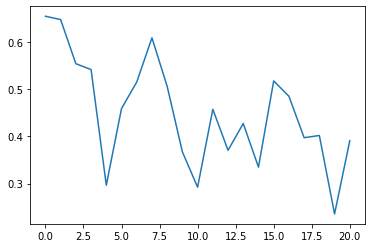

In [15]:
# Plot training losses
plt.plot(torch.tensor(lossi).view(-1, 1).mean(1))

In [16]:
model.eval()
t_predictions = []
t_targets = []
v_predictions = []
v_targets = []

threshold = 0.5

# Train Loss Calculations
with torch.no_grad():
    t_losses = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        loss = F.binary_cross_entropy(outputs, labels)
        t_losses.append(loss)
        # Version for getting every loss individually
#         loss = F.binary_cross_entropy(outputs, labels, reduction='none')
#         for idx in range(loss.shape[0]):
#             t_losses.append(loss[idx].mean())
        t_predictions.append(outputs.numpy())
        t_targets.append(labels.numpy())
        
train_avg_loss = np.array(t_losses).mean()
print("Train Loss:", train_avg_loss)

t_predictions = np.vstack(t_predictions)
t_targets = np.vstack(t_targets)

# Binary classification metrics
train_accuracy = metrics.accuracy_score(t_targets, (t_predictions > threshold).astype(int))
# train_precision = metrics.precision_score(t_targets, (t_predictions > threshold).astype(int), average='samples', zero_division=0)
# train_recall = metrics.recall_score(t_targets, (t_predictions > threshold).astype(int), average='samples')
train_f1 = metrics.f1_score(t_targets, (t_predictions > threshold).astype(int))
# train_roc_auc = metrics.roc_auc_score(t_targets, t_predictions, average='samples')

print(f'Accuracy: {train_accuracy:.4f}')
# print(f'Precision: {train_precision:.4f}')
# print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')
# print(f'ROC AUC: {train_roc_auc:.4f}')
print()

# Validation Loss Calculations
with torch.no_grad():
    v_losses = []
    for inputs, labels in val_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        #loss = F.binary_cross_entropy(outputs, labels)
        #v_losses.append(loss)
        # Version for getting every loss individually
        loss = F.binary_cross_entropy(outputs, labels, reduction='none')
        for idx in range(loss.shape[0]):
            v_losses.append(loss[idx].mean())
        v_predictions.append(outputs.numpy())
        v_targets.append(labels.numpy())
        
val_avg_loss = np.array(v_losses).mean()
print("Val Loss:", val_avg_loss)

v_predictions = np.vstack(v_predictions)
v_targets = np.vstack(v_targets)

# Binary classification metrics
accuracy = metrics.accuracy_score(v_targets, (v_predictions > threshold).astype(int))
# precision = metrics.precision_score(v_targets, (v_predictions > threshold).astype(int), average='samples', zero_division=0)
# recall = metrics.recall_score(v_targets, (v_predictions > threshold).astype(int), average='samples')
f1 = metrics.f1_score(v_targets, (v_predictions > threshold).astype(int))
# roc_auc = metrics.roc_auc_score(v_targets, v_predictions, average='samples')

print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
# print(f'ROC AUC: {roc_auc:.4f}')

Train Loss: 0.34538734
Accuracy: 0.8538
F1-score: 0.8090

Val Loss: 0.4553126
Accuracy: 0.7977
F1-score: 0.7189


In [18]:
# Printing incorrectly labelled tweets
# This dataset clearly isn't the highest quality because if you look through this list you'll find many incorrectly labelled
v_pred_float = (v_predictions > 0.5).astype(float)
mismatched_rows = np.where(v_targets != v_pred_float)[0]
print(len(mismatched_rows))

for row in mismatched_rows[:20]:
    tmp = (embedding_data2 == val_dataset[row][0])
    allone = (tmp == 1).all(dim=1)
    idx = torch.nonzero(allone, as_tuple=False).squeeze()
    if idx.dim() > 0:
        idx = idx[0].item()
    else:
        idx = idx.item()
    print(df.iloc[idx][3])
    print(idx)
    print(v_predictions[row])
    print(v_targets[row])
    print()

# ct = 0
# for tweet in df['text'].iloc[mismatched_rows]:
#     print(f'{mismatched_rows[ct]}: {tweet}')
#     ct += 1

140
USER a nuclear bomb is a terrible weapon
6548
[0.42130196]
[1.]

the efak would be designed for building occupants once they evacuate and report to their evacuation assembly sites
3069
[0.13988927]
[1.]

USER  infosec rather you knew it or not your a firefighter  now days  you often  run into burning buildings deal with it
1111
[0.726381]
[0.]

as of 2010 there were 17 beluga deaths reported at seaworld their average age 15 12 years opseaworld URL
2015
[0.4233361]
[1.]

from recycling to only using nonhazardous chemicals holland 1916 continually strives to maintain an ecofriendly existence
3930
[0.21068113]
[1.]

afghan peace talks in doubt after mullah omars death  financial times  mullah
1974
[0.7673603]
[0.]

biolab safety concerns grow fedex stops transporting certain specimens research facilities dumbfounded by action URL
542
[0.72467214]
[0.]

after a few years afloat pension plans start sinking again URL
5533
[0.25490612]
[1.]

USER  do anything to fix that of the few people

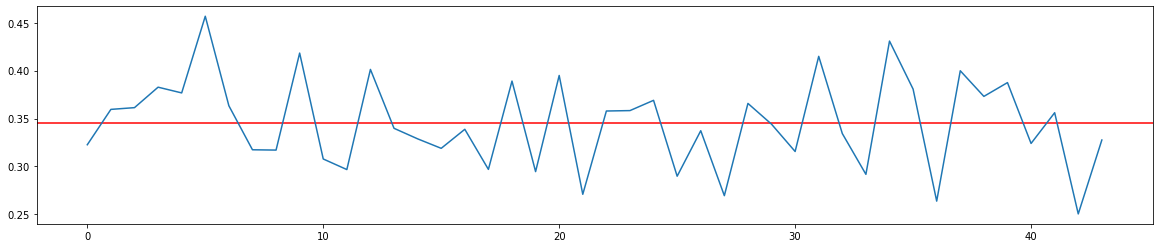

In [19]:
# For plotting train losses
plt.figure(figsize=(20,4))
plt.axhline(y = train_avg_loss, color = 'r', linestyle = '-') 
plt.plot(t_losses)

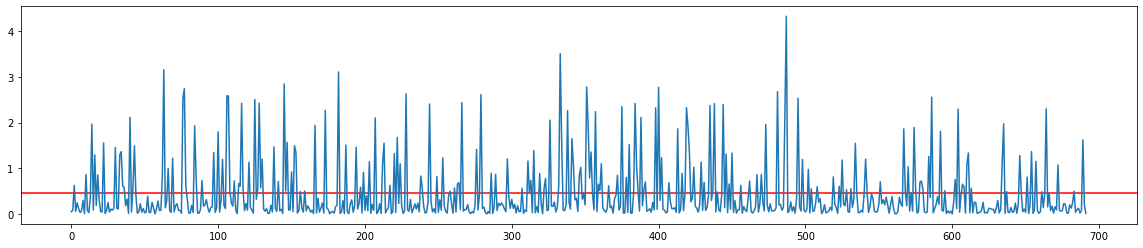

In [20]:
# For plotting val losses
plt.figure(figsize=(20,4))
plt.axhline(y = val_avg_loss, color = 'r', linestyle = '-') 
plt.plot(v_losses)

layer 0 ( RelU 0): mean +1.32, std 1.30, saturated: 22.00%
layer 1 ( RelU 1): mean +3.10, std 2.96, saturated: 16.11%


Text(0.5, 1.0, 'activation distribution')

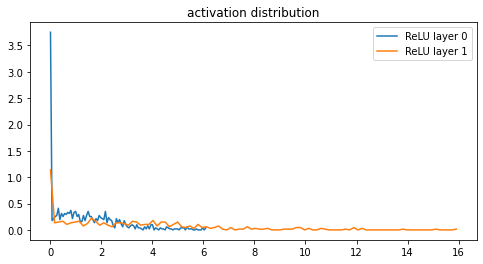

In [21]:
# Visualize Activation Distribution
plt.figure(figsize=(8, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_outputs):
    t = output
    print('layer %d (%7s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "RelU " + str(i), t.mean(), t.std(), (t == 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends)
plt.title('activation distribution')

layer 0 (    RelU 0): mean -0.000076, std 2.875446e-03
layer 1 (    RelU 1): mean +0.000131, std 1.456043e-03


Text(0.5, 1.0, 'gradient distribution')

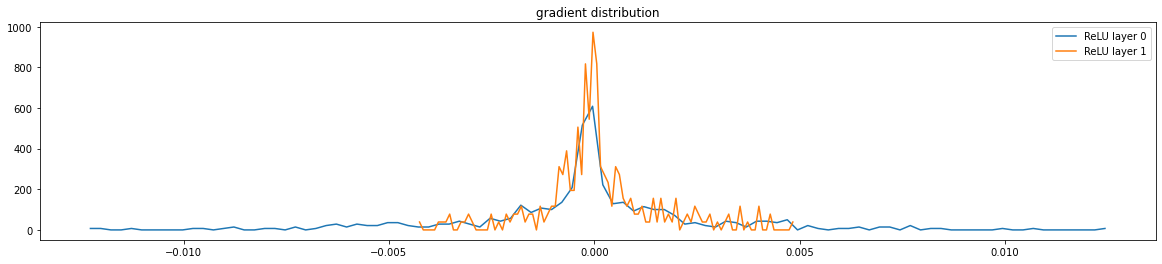

In [22]:
# Visualize Gradient Distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_grads):
    t = output
    print('layer %d (%10s): mean %+f, std %e' % (i, "RelU " + str(i), t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    #hy /= hy.sum() # normalize, not sure about adding this yet. For consistency I'm leaving it out, may add later.
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends);
plt.title('gradient distribution')

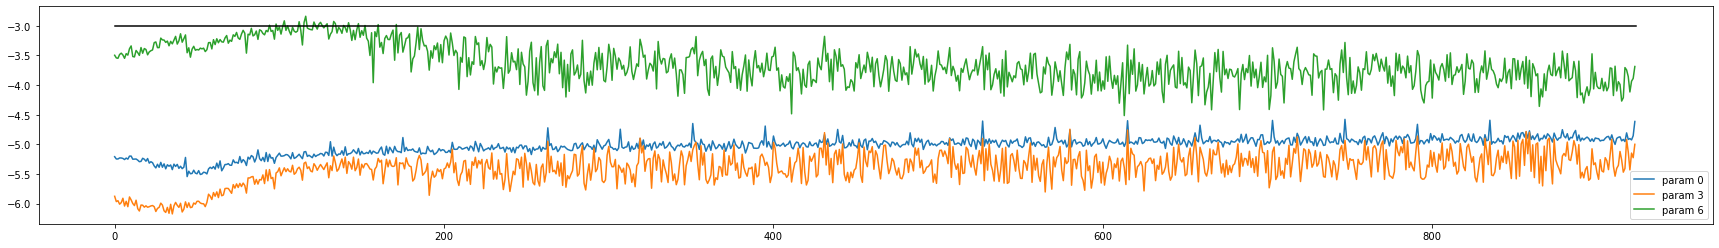

In [23]:
# Visualize Update-to-Data Ratio
plt.figure(figsize=(30, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [24]:
test_predictions = []
test_targets = []
threshold = 0.5

# Test Loss Calculations
with torch.no_grad():
    test_losses = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        #loss = F.binary_cross_entropy(outputs, labels)
        #test_losses.append(loss)
        # Version for getting every loss individually
        loss = F.binary_cross_entropy(outputs, labels, reduction='none')
        for idx in range(loss.shape[0]):
            test_losses.append(loss[idx].mean())
        test_predictions.append(outputs.numpy())
        test_targets.append(labels.numpy())
        
test_avg_loss = np.array(test_losses).mean()
print("Test Loss:", test_avg_loss)

test_predictions = np.vstack(test_predictions)
test_targets = np.vstack(test_targets)

# Binary classification metrics
accuracy = metrics.accuracy_score(test_targets, (test_predictions > threshold).astype(int))
# precision = metrics.precision_score(v_targets, (v_predictions > threshold).astype(int), average='samples', zero_division=0)
# recall = metrics.recall_score(v_targets, (v_predictions > threshold).astype(int), average='samples')
f1 = metrics.f1_score(v_targets, (v_predictions > threshold).astype(int))
# roc_auc = metrics.roc_auc_score(v_targets, v_predictions, average='samples')

print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
# print(f'ROC AUC: {roc_auc:.4f}')

Test Loss: 0.45063674
Accuracy: 0.8023
F1-score: 0.7189


In [30]:
test_df = pd.read_csv('test.csv')

In [31]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [32]:
# Pre-Processing

# Only leave necessary characters in tweets
test_df['text'] = test_df['text'].str.replace(r'[^a-zA-Z0-9@ ]', '', regex=True)

# Convert all tweets to lowercase
test_df['text'] = test_df['text'].str.lower()

# Convert tweets with more than 2 repeating characters to just 2
test_df['text'] = test_df['text'].str.replace(r'(.)(\1+)', r'\1\1', regex=True)

# Convert all urls to 'URL'
test_df['text'] = test_df['text'].str.replace(r'http\S+', 'URL', regex=True)

# Convert all @ user mentions to 'USER'
test_df['text'] = test_df['text'].str.replace(r'@\S+', 'USER', regex=True)

# # Add numerical representation of keyword column
# label_encoder = LabelEncoder()
# test_df['keyword_num'] = label_encoder.fit_transform(test_df['keyword'])

test_df.shape

(3263, 4)

In [135]:
%%time
# Generate embeddings for tweets
#sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')
sent_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #embeddings1

def embedding(texts):
    embs = sent_model.encode(texts)
    return embs

n_cores = 4
batch_size = 64

def process_batch(i):
    batch_texts = test_df['text'].iloc[i:i+batch_size].tolist()
    batch_embeddings = embedding(batch_texts)
    return batch_embeddings

# embeddings = Parallel(n_jobs=n_cores)(
#     delayed(process_batch)(i) for i in range(0, len(test_df), batch_size))

# flat_embeddings = [emb for batch in embeddings for emb in batch]
# test_df['embeddings1'] = flat_embeddings

# test_embedding_data = torch.tensor(np.vstack(test_df['embeddings1'].values), dtype=torch.float32)
# torch.save(test_embedding_data, 'test_embeddings1.pt')

CPU times: total: 2min 52s
Wall time: 11min 51s


In [33]:
load_test_embedding1 = torch.load("test_embeddings1.pt").numpy()
load_test_embedding1 = [row for row in load_test_embedding1]
load_test_embedding2 = torch.load("test_embeddings2.pt").numpy()
load_test_embedding2 = [row for row in load_test_embedding2]

test_df['embeddings1'] = load_test_embedding1
test_df['embeddings2'] = load_test_embedding2
test_df.head()

,id,keyword,location,text,embeddings1,embeddings2
0,0,NaN,NaN,just happened a terrible car crash,"[0.014579057, 0.0014145372, 0.084909655, 0.019...","[-0.027418124, -0.026864067, -0.01665942, -0.0..."
1,2,NaN,NaN,heard about earthquake is different cities sta...,"[0.10137003, -0.029703327, 0.071773484, 0.0506...","[-0.03524543, 0.057101414, -0.05105066, 0.0330..."
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,"[0.090372995, 0.011535411, 0.018954232, -0.024...","[-0.037914146, 0.03210508, -0.009361354, 0.004..."
3,9,NaN,NaN,apocalypse lighting spokane wildfires,"[0.023855345, 0.11241103, 0.05615822, 0.060822...","[-0.06004176, 0.13002928, 0.0020221309, -0.018..."
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,"[0.061023206, 0.04848834, -0.031156389, 0.0557...","[-0.021391058, -0.063904844, 0.011692984, -0.0..."


In [34]:
def model_test(emb):
    model.eval()
    emb = torch.from_numpy(emb)
    with torch.no_grad():
        out = model(emb.reshape(1,-1))
        return (out > 0.5).int().item()
        
test_df['target'] = test_df['embeddings2'].apply(model_test)
#test_df['target1'] = test_df['embeddings1'].apply(model_test)

In [35]:
final = test_df[['id', 'target']]
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [140]:
#final.to_csv('submission3.csv', index=False)